## Kalman Filter Linear Regression

`Kalman Filter` is a state space model that assumes the system state evolves by some hidden and unobservable pattern. Instead we can only observe some measurable features from the system, based on which we try to guess the current state of the system.
The hard part is to design a system that reflects the reality, and after that it's just a matter of following the mechanical steps.
In our simple linear example the state variable $\theta$ contains intercept and slope and is assumed to follow a transition equation of random walk with Gaussian innovations:
$$
\theta_k = \begin{bmatrix} a_k \\\\ b_k \end{bmatrix} =\theta_{k-1} + w_t
$$
where $a_k$ and $b_k$ are intercept and slope, respectively. 
After the state is transited, it's time to observe the system. Because it takes two points to determine a line, it is assumed to observe two points $(x_{1,t}, y_{1,t})$ and $(x_{2,t}, y_{2,t})$. The measurement equation can be re-written as,
$$
y_t =\begin{bmatrix} y_{1,t} \\\\ y_{2,t} \end{bmatrix}=\begin{bmatrix} 1 & x_{1,t} \\\\ 1 & x_{2,t}\end{bmatrix}  \begin{bmatrix} a_t \\\\ b_t \end{bmatrix} + v_t
$$
The last thing we need to start the system is the initial value $\theta_{0|0}$ and $P_{0|0}$. 

posterior mean over 250 steps:  a = 1.1996, b = 1.8106


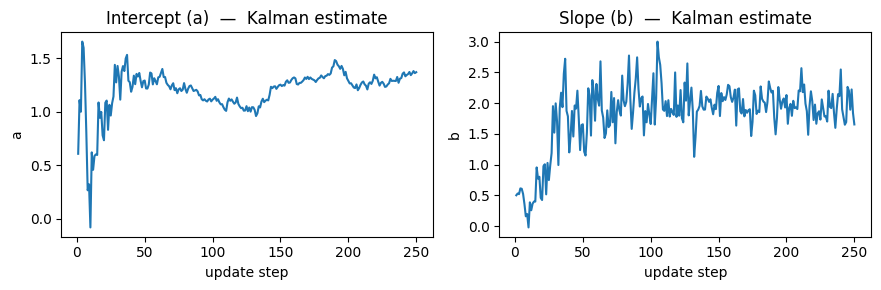

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 0)  generate 500 synthetic points  y = 2x + 1 + ε
# -------------------------------------------------
np.random.seed(42)
n_pts    = 500
sigma_e  = 3.0                                 # observation noise std
x        = np.linspace(0, 10, n_pts)
y        = 2.0 * x + 1.0 + np.random.normal(0, sigma_e, n_pts)

# -------------------------------------------------
# 1)  Kalman-filter settings for dynamic y = a + b x
# -------------------------------------------------
#   state vector θ_k = [a_k, b_k]ᵀ
#   state transition: θ_k = θ_{k-1} + w_k (random walk)
#   process-noise covariance W
#   measurement noise v_k ~ N(0, σ_e² I₂)
#
theta_0  = np.array([[0.5],    # prior mean for a
                     [0.5]])   # prior mean for b
P_0      = np.diag([0.5**2, 0.5**2])  # prior covariance
W        = np.diag([0.5**2, 0.5**2])  # process noise (can tweak)

V        = sigma_e**2 * np.eye(2)     # measurement-noise cov (2×2)

# storage for posterior means at each step
n_pairs  = n_pts // 2                 # 250 updates (2 points per update)
posterior_trace = np.zeros((n_pairs, 2))

theta_prior = theta_0.copy()
P_prior     = P_0.copy()

for k in range(n_pairs):
    # ---------- 1. time-update ("predict") ----------
    theta_pred = theta_prior           # random walk, so mean stays
    P_pred     = P_prior + W           # covariance increases by W

    # ---------- 2. measurement for two fresh points ----------
    i1, i2 = 2*k, 2*k + 1
    x1, y1 = x[i1], y[i1]
    x2, y2 = x[i2], y[i2]

    y_vec  = np.array([[y1],
                       [y2]])
    H      = np.array([[1, x1],
                       [1, x2]])        # observation matrix (2×2)

    # innovation
    y_tilde = y_vec - H @ theta_pred
    S       = H @ P_pred @ H.T + V      # innovation covariance
    K       = P_pred @ H.T @ np.linalg.inv(S)  # Kalman gain

    # ---------- 3. state-update ("correct") ----------
    theta_post = theta_pred + K @ y_tilde
    P_post     = (np.eye(2) - K @ H) @ P_pred

    # store and feed into next round
    posterior_trace[k] = theta_post.flatten()
    theta_prior, P_prior = theta_post, P_post

print(f"posterior mean over 250 steps:  a = {posterior_trace[:,0].mean():.4f}, "
      f"b = {posterior_trace[:,1].mean():.4f}")

# -------------------------------------------------
# 2)  plot the hidden-state evolution
# -------------------------------------------------
steps = np.arange(1, n_pairs+1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

ax1.plot(steps, posterior_trace[:,0])
ax1.set_title("Intercept (a)  —  Kalman estimate")
ax1.set_xlabel("update step"); ax1.set_ylabel("a")

ax2.plot(steps, posterior_trace[:,1])
ax2.set_title("Slope (b)  —  Kalman estimate")
ax2.set_xlabel("update step"); ax2.set_ylabel("b")

plt.tight_layout();  plt.show()
